# Chapitre 2
Ce TP a pour objectif de mettre en pratique les concepts vus en cours concernant la représentation vectorielle des mots et documents. Il aborde les points suivants:

* Apprentissage d'un modèle word2vec pour les word embeddings
* Visualisation des word embeddings
* Evaluation des embeddings
   * Evaluation intrinsèque en utilisant un dataset de similarité annoté par des humains
   * Evaluation extrinsèque sur une tâche de classification de texte  
* Calcul de représentations vectorielles de documents

# Entraînement d'embeddings Word2Vec avec Gensim
Dans cette première partie, nous allons utiliser la library gensim afin d'entraîner un modèle Word2Vec sur le dataset [Quora Question Pairs](https://www.kaggle.com/competitions/quora-question-pairs/overview). Ce dataset contient 400 000 pairs de questions avec un label indiquant si les questions forment un doublon.  
Dans cette première partie, par souci de simplicité, nous n'allons considérer que la colonne question1 du dataset. L'objectif étant d'entraîner un modèle Word2Vec sur ces données.  

## Téléchargement des données
Téléchargez les données du dataset Quora Question Pairs à partir de Kaggle (on ne prendra que le split de train)

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

questions = r'/content/drive/MyDrive/TP IA-NLP/quora_questions/train.csv'

Mounted at /content/drive


## Chargement des données
Chargez le dataset téléchargé dans un dataset et visualiser celui-ci afin d'avoir une idée de son contenu (voir quelques exemples, taille, ...)

In [2]:
df_train = pd.read_csv(questions)
df_train
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Preprocessings
Effectuez quelques preprocessings que vous jugez nécessaires sur le dataset pour l'entraînement.  
Quelques exemples :
* Choix de la tokenisation  
* Lemmatisation  
* Suppression des stopwords  
* Supression de caractères spéciaux  
* Mettre en minuscule  

Vous pouvez utiliser spacy et/ou nltk pour cela.  
Les effets de certains preprocessings peuvent être positifs ou négatifs et il n'est parfois pas possible de le savoir à priori. Il ne faut donc pas hésiter à expérimenter et revenir à cette partie pour améliorer votre preprocessing selon l'évaluation que vous effectuez (par exemple en se basant sur les performances des tâches testées plus loin)  



In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re

# Télécharger les ressources nécessaires
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Initialiser les ressources
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# S'assurer que toutes les entrées sont des chaînes de caractères et gérer les valeurs manquantes
df_train['question1'] = df_train['question1'].fillna('').astype(str)
df_train['question2'] = df_train['question2'].fillna('').astype(str)

# Fonction pour obtenir le type de mot pour lemmatisation
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('V'):
        return 'v'  # Verbes
    elif treebank_tag.startswith('N'):
        return 'n'  # Noms
    elif treebank_tag.startswith('J'):
        return 'a'  # Adjectifs
    else:
        return None

# Fonction pour tokeniser, lemmatiser et supprimer les stopwords
def pre_process(text):
    # Mettre en minuscule
    text = text.lower()
    # Supprimer les caractères spéciaux en gardant les mots et les espaces
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Tokenisation avec nltk
    words = word_tokenize(text)
    # Partie du discours pour chaque mot
    pos_tags = pos_tag(words)
    # Lemmatisation et suppression des stopwords avec gestion du POS
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos) if get_wordnet_pos(pos) else 'n')
                        for word, pos in pos_tags if word not in stop_words]
    return lemmatized_words

df_train['question1'] = df_train['question1'].apply(pre_process)
df_train['question2'] = df_train['question2'].apply(pre_process)

# Afficher les résultats pour vérifier
print(df_train[['question1', 'question2']].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


                                           question1  \
0  [step, step, guide, invest, share, market, india]   
1               [story, kohinoor, kohinoor, diamond]   
2  [increase, speed, internet, connection, use, vpn]   
3                          [mentally, lonely, solve]   
4  [one, dissolve, water, quikly, sugar, salt, me...   

                                           question2  
0         [step, step, guide, invest, share, market]  
1  [would, happen, indian, government, steal, koh...  
2             [internet, speed, increase, hack, dns]  
3                [find, remainder, mathmath, divide]  
4                [fish, would, survive, salt, water]  


## Entraînement du modèle  
Effectuez l'apprentissage en utilisant la classe [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) de gensim.  
Cette classe permet d'entraîner le modèle et de spécifier plusieurs hyperparamètres (taille de la fenêtre, algorithme d'entraînement Skip-Gramd ou CBOW, nombre d'exemples pour le negative sampling, ...)  

**Note** : Afin de ne pas perdre votre travail, vous pouvez sauvegarder vos embeddings et les télécharger sur votre machine.

In [4]:
import gensim
from gensim.models import Word2Vec
import numpy as np

# Préparer les données sous forme de liste de listes de tokens
# Vous pouvez choisir d'utiliser uniquement 'question1' ou combiner 'question1' et 'question2' pour entraîner le modèle
sentences = df_train['question1'].tolist() + df_train['question2'].tolist()

# Entraîner le modèle Word2Vec
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=5, sg=1, workers=4)

# Sauvegarder le modèle
word2vec_model.save("word2vec_model.model")

# Sauvegarder les embeddings dans un fichier texte pour téléchargement
word2vec_model.wv.save_word2vec_format("word2vec_embeddings.txt")

# Vous pouvez aussi accéder directement à l'embedding d'un mot
embedding_of_example_word = word2vec_model.wv['example']  # Remplacez 'example' par un mot de votre choix
print(embedding_of_example_word)

# Pour récupérer tous les embeddings dans un tableau numpy
embeddings = np.array([word2vec_model.wv[word] for word in word2vec_model.wv.index_to_key])

# Vérifiez les dimensions des embeddings
print(embeddings.shape)


[ 6.03587590e-02  2.09627360e-01  1.10369757e-01 -3.61676574e-01
 -1.29961371e-01 -5.36594838e-02  4.61742461e-01  4.71574783e-01
  3.92718703e-01  6.94847345e-01  2.97301143e-01 -5.75958788e-01
 -5.61118245e-01 -6.13846421e-01  6.97772384e-01  2.48982888e-02
 -2.03101084e-01 -4.46676522e-01 -5.08695781e-01  2.18667448e-01
  3.03992331e-01 -9.27598309e-03  2.59879027e-02 -2.46231295e-02
 -5.37527092e-02  1.65826142e-01 -2.91202307e-01  6.34749949e-01
 -4.79646355e-01  3.69848199e-02  4.04195428e-01  1.04697794e-01
 -3.13968249e-02 -8.15056488e-02  5.78975797e-01 -8.57292891e-01
 -8.76371711e-02 -3.33341390e-01 -4.69621152e-01 -2.76145339e-01
 -1.69130623e-01  2.32229307e-01  1.56801805e-01 -1.16682805e-01
 -2.07465976e-01 -6.76140130e-01  5.27087376e-02  1.01189703e-01
  2.22725317e-01 -2.56471813e-01  4.01755899e-01  2.09420105e-03
 -3.83853614e-01  3.47489938e-02 -1.04368389e-01  6.11720860e-01
  8.05003271e-02  1.73698083e-01 -1.80008039e-01 -2.31195077e-01
 -1.17289327e-01 -8.22736

## Visualisation des embeddings  
Pour juger rapidement de la pertinence de vos embeddings, printez quelques exemples:  
* Les mots les plus similaires à un mot cible (utiliser la fonction most_similar du modèle word2vec)  
* Vérifiez si votre modèle d'embedding permet de trouver des solutions à la tâche d'analogies (vous pouvez utiliser la fonction most_similar, par ex :



```
model.wv.most_similar(positive=["woman", "king"], negative=["queen"], topn=3))  
```

* Visualisez vos embeddings sur un scatter plot:  
    * Effectuez d'abord une réduction de la dimension des embeddings avec la classe [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) ou encore en utilisant UMAP ou une PCA.  
    * Plottez vos embeddings sur le plan. Vous pouvez sélectionner un échantillon de mot. La library plotly vous permettra d'avoir un plot interactif. Vous pouvez aussi sauvegarder vos embeddings au format TSV et les visualiser grâce à l'[Embedding Projector Tensorflow](https://projector.tensorflow.org/)

In [5]:
from gensim.models import Word2Vec

# Charger le modèle préalablement sauvegardé
model = Word2Vec.load("word2vec_model.model")
# Exemple de recherche des mots les plus similaires à "king"
similar_words = model.wv.most_similar('king', topn=5)
print("Mots les plus similaires à 'king':")
for word, similarity in similar_words:
    print(f"{word}: {similarity}")




Mots les plus similaires à 'king':
petyr: 0.5730542540550232
luther: 0.5722944140434265
baratheon: 0.5519255995750427
theon: 0.5488587617874146
jr: 0.5465019345283508


In [6]:
analogy_result = model.wv.most_similar(positive=["woman", "king"], negative=["queen"], topn=3)
print("Résultat de l'analogie:")
for word, similarity in analogy_result:
    print(f"{word}: {similarity}")

Résultat de l'analogie:
men: 0.49360331892967224
heterosexual: 0.476050466299057
womens: 0.43419283628463745


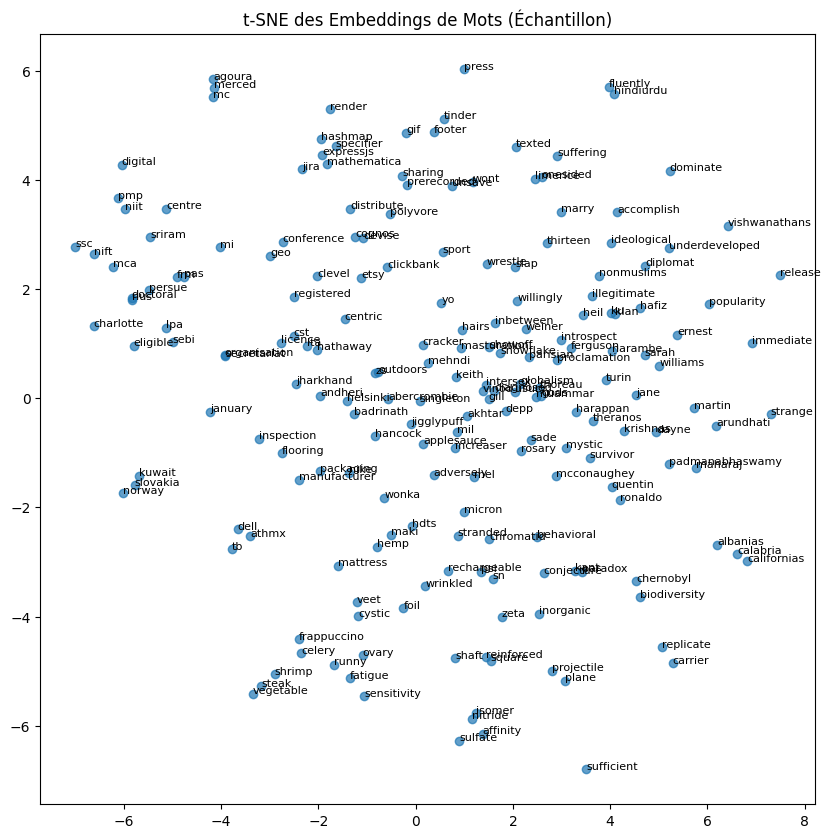

In [7]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

# Extraire les vecteurs des mots du modèle Word2Vec
word_vectors = model.wv[model.wv.key_to_index.keys()]  # Récupère les embeddings de tous les mots dans le vocabulaire

# Sélectionner un échantillon de mots (par exemple 200 mots)
sample_words = random.sample(list(model.wv.key_to_index.keys()), 200)

# Extraire les vecteurs de ces mots
sample_word_vectors = np.array([model.wv[word] for word in sample_words])  # Convertir en tableau NumPy

# Réduction dimensionnelle avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(sample_word_vectors)

# Plot des embeddings
plt.figure(figsize=(10, 10))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.7)
for i, word in enumerate(sample_words):
    plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=8)
plt.title('t-SNE des Embeddings de Mots (Échantillon)')
plt.show()



# Evaluation du modèle entraîné  
Votre modèle word2vec étant entraîné, nous allons l'évaluer sur le dataset [SimLex-999](https://fh295.github.io/simlex.html) qui contient des paires de mots et une annotation humaine de la similarité entre eux.  
L'idée est de calculer la corrélation entre la mesure de similarité de votre modèle et celle de l'annotation.  


## Téléchargement et chargement du dataset
Téléchargez le dataset SimLex-999 et chargez-le sur un dataframe pandas  
Téléchargez aussi un modèle d'embeddings word2vec pré-entraîné. Par exemple:  

```
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')
```

On va utiliser ce modèle afin de le comparer à celui qu'on a entraîné.





In [8]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')
# Charger le dataset SimLex-999
df_simlex = pd.read_csv('/content/drive/MyDrive/TP IA-NLP/SimLex-999.txt', sep="\t")
df_simlex.head()

# Fonction modifiée pour calculer la similarité
def get_similarity(model, word1, word2):
    try:
        # Vérifier si le modèle est un KeyedVectors ou un Word2Vec
        if hasattr(model, 'wv'):  # Pour votre modèle entraîné
            similarity = model.wv.similarity(word1, word2)
        else:  # Pour le modèle pré-entraîné, qui est déjà un KeyedVectors
            similarity = model.similarity(word1, word2)
    except KeyError:
        similarity = None  # Si un mot n'est pas dans le vocabulaire, retourner None
    return similarity


# Calcul des similarités avec votre modèle entraîné
df_simlex['similarity_model'] = df_simlex.apply(lambda row: get_similarity(model, row['word1'], row['word2']), axis=1)

# Calcul des similarités avec le modèle pré-entraîné
df_simlex['similarity_pretrained'] = df_simlex.apply(lambda row: get_similarity(wv, row['word1'], row['word2']), axis=1)

# Afficher les résultats pour vérifier
df_simlex.head()

# Afficher les résultats
print(df_simlex.head())

# Calculer la corrélation en utilisant la colonne 'SimLex999'
correlation_model = df_simlex['SimLex999'].corr(df_simlex['similarity_model'])
correlation_pretrained = df_simlex['SimLex999'].corr(df_simlex['similarity_pretrained'])

print(f"Corrélation entre votre modèle et les annotations humaines: {correlation_model}")
print(f"Corrélation entre le modèle pré-entraîné et les annotations humaines: {correlation_pretrained}")


[==================================================] 100.0% 1662.8/1662.8MB downloaded
   word1        word2 POS  SimLex999  conc(w1)  conc(w2)  concQ  Assoc(USF)  \
0    old          new   A       1.58      2.72      2.81      2        7.25   
1  smart  intelligent   A       9.20      1.75      2.46      1        7.11   
2   hard    difficult   A       8.77      3.76      2.21      2        5.94   
3  happy     cheerful   A       9.55      2.56      2.34      1        5.85   
4   hard         easy   A       0.95      3.76      2.07      2        5.82   

   SimAssoc333  SD(SimLex)  similarity_model  similarity_pretrained  
0            1        0.41          0.300229               0.222780  
1            1        0.67          0.499577               0.649528  
2            1        1.19          0.499880               0.602575  
3            1        2.18               NaN               0.383774  
4            1        0.93          0.296586               0.470963  
Corrélation entre 

## Calcul de la similarité
Créez deux nouvelles colonnes dans la dataframe contenant la similarité telle que calculée en utilisant vos embeddings et ceux du modèle pré-entraîné.

## Analyse de la corrélation
Calculez la corrélation deux à deux entre les 3 similarités (humaine, votre modèle, le modèle pré-entraîné)  

Vous pouvez utiliser la fonction [pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) de scipy et utiliser seaborn (ou une autre library) pour visualiser les fonctionnalités de la library seaborn pour avoir des visualisation de cette corrélation. Exemple de plot possible:

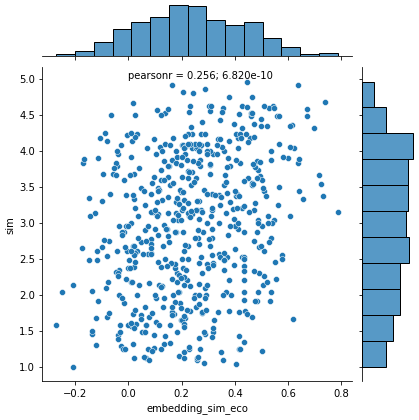

# Embeddings de documents
Dans cette partie, nous allons comparer 3 méthodes de représentations des documents sur une tâche de classification de texte:  
* Une représentation tf-idf  
* Une représentation en utilisant vos embeddings  
* Une représentation en utilisant des embeddings pré-entraînés  

Nous allons utiliser le dataset d'avis amazon du TP1 qui contient la note donnée dans chaque review au produit. Par souci de simplicité, nous allons transformer la note donnée (entre 1 et 5) en deux classes:

0 : quand la note est entre 1 et 3 pour exprimer un sentiment négatif
1 : quand la note est entre 4 et 5 pour exprimer un sentiment positif
L'objectif étant de faire l'apprentissage d'un modèle sur le split de train pour ensuite l'évaluer sur le split de test.

## Téléchargement et chargement du dataset
Téléchargez le dataset amazon avec la fonction load_dataset de la library datasets. Chargez le dataset de train et de test dans un dataframe pandas.  

**Attention**: Contraitement au TP1, ici on ne garde que les reviews en anglais (on travaille avec des corpus et modèles d'embeddings en anglais)

In [9]:
amazon = r'/content/drive/MyDrive/TP IA-NLP/amazon/train.csv'
df_amazon = pd.read_csv(amazon)


## Preprocessings
Effectuez les preprocessings que vous jugez pertinents sur le texte du dataset (tokenisation, ...)

In [10]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re

# Initialiser les ressources
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Fonction pour obtenir le type de mot pour la lemmatisation
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('J'):
        return 'a'
    else:
        return 'n'

# Fonction pour appliquer le preprocessing sur les textes
def pre_process_english(text):
    # Mettre en minuscule
    text = text.lower()
    # Supprimer les caractères spéciaux
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Tokenisation
    words = word_tokenize(text)
    # Obtenir le POS pour chaque mot
    pos_tags = pos_tag(words)
    # Lemmatiser et supprimer les stopwords
    lemmatized_words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in pos_tags if word not in stop_words
    ]
    return lemmatized_words

# Filtrer les lignes où la langue est 'en' (anglais)
df_amazon = df_amazon[df_amazon['language'] == 'en']

# Appliquer la fonction de preprocessing sur la colonne 'review_body'
df_amazon['review_body'] = df_amazon['review_body'].apply(pre_process_english)

# Supprimer les lignes avec des valeurs 'None' (au cas où certaines lignes n'ont pas pu être traitées)
df_amazon = df_amazon.dropna(subset=['review_body'])

# Afficher quelques exemples après preprocessing
df_amazon['review_body']  # Afficher les 10 premiers exemples


,review_body
200000,"[arrive, broken, manufacturer, defect, two, le..."
200001,"[cabinet, dot, detach, back, get]"
200002,"[receive, first, order, product, break, order,..."
200003,"[product, piece, shit, buy, doesnt, work, try,..."
200004,"[go, one, day, doesnt, fit, correct, couldnt, ..."
...,...
399995,"[cute, slipper, mil, love]"
399996,"[year, old, like, keep, engage, doesnt, really..."
399997,"[replace, battery, work, like, new]"
399998,"[like, hold, well]"


## Calcul des embeddings de documents
Calculez les embeddings des documents selon les 3 approches:  
* tf-idf : en utilisant le [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) de sklearn  
* votre word2vec: en utilisant les embeddings que vous avez mis en oeuvre précédemment  
* word2vec pré-entraîné: en utilisant le word2vec pré-entraîné précédemment utilisé, ou une autre représentation vectorielle pré-entraînée (fasttext par exemple)  

**Note**: Pour le tf-idf, la représentation qu'on obtient est une représentation vectorielle du document. Cependant, pour les modèles d'embeddings qui calculent des embeddings de mots, il faut écrire une fonction pour construire l'embedding du document à partir de ceux de ces mots (en prenant le centroïde/la moyenne par exemple).



In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_tfidf =  TfidfVectorizer() #embeddings tfidf
X_wv_quora = model # embeddings avec word2vec entraîné sur Quora
X_wv = wv  # embeddings avec word2vec (ou autre) pré-entraîné

## Entraînement du modèle de classification
Effectuez l'apprentissage de trois modèles de classification très simples sur la tâche de classification de sentiment sur le dataset de train. Evaluez les sur le dataset de test et comparez-les.  

Vous pouvez utiliser des modèles de classification sklearn tel qu'un réseau de neurones peu profond voire à une seule couche, ou bien un naive bayes. L'idée étant de garder le même modèle pour les 3 représentations et d'avoir un modèle simple afin d'évaluer la qualité des embeddings.  



AttributeError: 'list' object has no attribute 'lower'